# Compressed sensing in Astronomy

In this Notebook we will implement the isotropic undecimated wavelet transform, aka the starlet transform, which is a sparse base for compressed sensing applied to astronomy. Then we will test this transform with 4 different algorithms on real data : Soft-Thresholding, Hard-Thresholding, Iterative multiresolution mask denoising algorithm and Independent composant analysis.

#### The starlet transform and the four algorithms are defined in models.py

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pyfits as pyf
#import algorithms and the starlet transform
import models

# Get the data

hdulist = pyf.open('ngc2997.fits')
x = np.double(hdulist[0].data)
hdulist.close()

Populating the interactive namespace from numpy and matplotlib


#### The ground truth image is the following : 

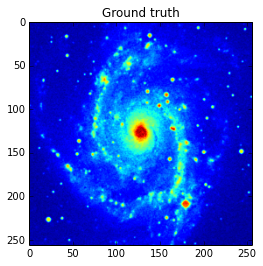

In [2]:
plt.imshow(x)
plt.title('Ground truth')
plt.show()

#### Now let's say we only have sampled measurements of the true image, and we add noise over these measurements.

In [3]:
# Get sampled measurements

for i in range(len(x)):
    for j in range(len(x[i])):
        if random.uniform(0, 1) > 0.7:
            x[i][j] = 0

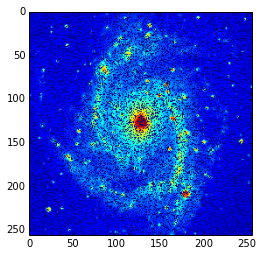

In [4]:
plt.imshow(x)
plt.show()

In [5]:
# Add some noise

n = 50 * np.random.randn(256, 256)
bn = x + n

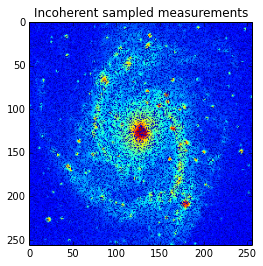

In [6]:
plt.imshow(bn)
plt.title('Incoherent sampled measurements')
plt.show()

#### We want to retreive the closest estimate to the real image. We use 3 algorithms for this task : Soft-Thresholding, Hard-Thresholding and Iterative multiresolution mask denoising algorithm.

In [8]:
# Compute the reconstructed image

x_st = models.SoftTHRD(bn, J=3, kmad=40)
print('SoftTHRD done')
x_ht = models.HardTHRD(bn, J=3, kmad=40)
print('HardTHRD done')
x_mr, mask = models.MRDenoise(bn, J=3, nmax=25, kmad=40)
print('MRDenoise done')

SoftTHRD done
HardTHRD done
MRDenoise done


#### Here are the results :

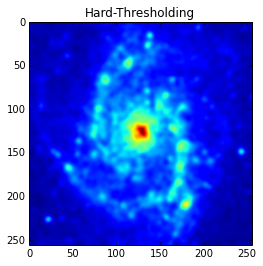

In [326]:
plt.imshow(x_ht)
plt.title('Hard-Thresholding')
plt.show()

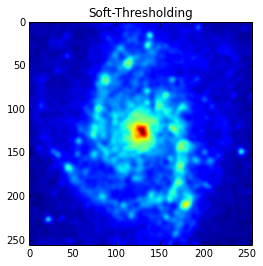

In [327]:
plt.imshow(x_st)
plt.title('Soft-Thresholding')
plt.show()

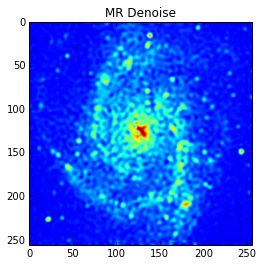

In [328]:
plt.imshow(x_mr)
plt.title('MR Denoise')
plt.show()

### Qualitatively, the results seem to be satisfying. Indeed, we can observe that the structure of the galaxy is recovered.

## In order to quantitatively evualuate the reconstructing and denoising task, we will use a metric.

We will use the Froebenius norm of the difference between the original image and the reconstructed one, i.e : 

$$ l(x,\widehat{x})=\|  x-\widehat{x}\|_F=\sqrt{\sum_{j=1}^{n}\sum_{i=1}^{n}(x_{i,j} - \widehat{x}_{i,j})^2}   $$

### First, the error as a function of the noise.

In [150]:
err_bn = []
err_st = []
err_ht = []
err_mr = []

# Get the data

hdulist = pyf.open('data_tp2/ngc2997.fits')
x = np.double(hdulist[0].data)
hdulist.close()

for i in range(8):

    n = i * 50 * np.random.randn(256, 256)

    bn = x + n
    err_bn.append(
        np.linalg.norm(x - bn, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))

    x_st = models.SoftTHRD(bn, J=3, kmad=2.4)
    err_st.append(
        np.linalg.norm(x - x_st, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))
    x_ht = models.HardTHRD(bn, J=3, kmad=2.4)
    err_ht.append(
        np.linalg.norm(x - x_ht, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))
    x_mr, mask = models.MRDenoise(bn, J=3, nmax=25, kmad=2.4)
    err_mr.append(
        np.linalg.norm(x - x_mr, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))

    print(i + 1, 'iterations done')

(1, 'iterations done')
(2, 'iterations done')
(3, 'iterations done')
(4, 'iterations done')
(5, 'iterations done')
(6, 'iterations done')
(7, 'iterations done')
(8, 'iterations done')


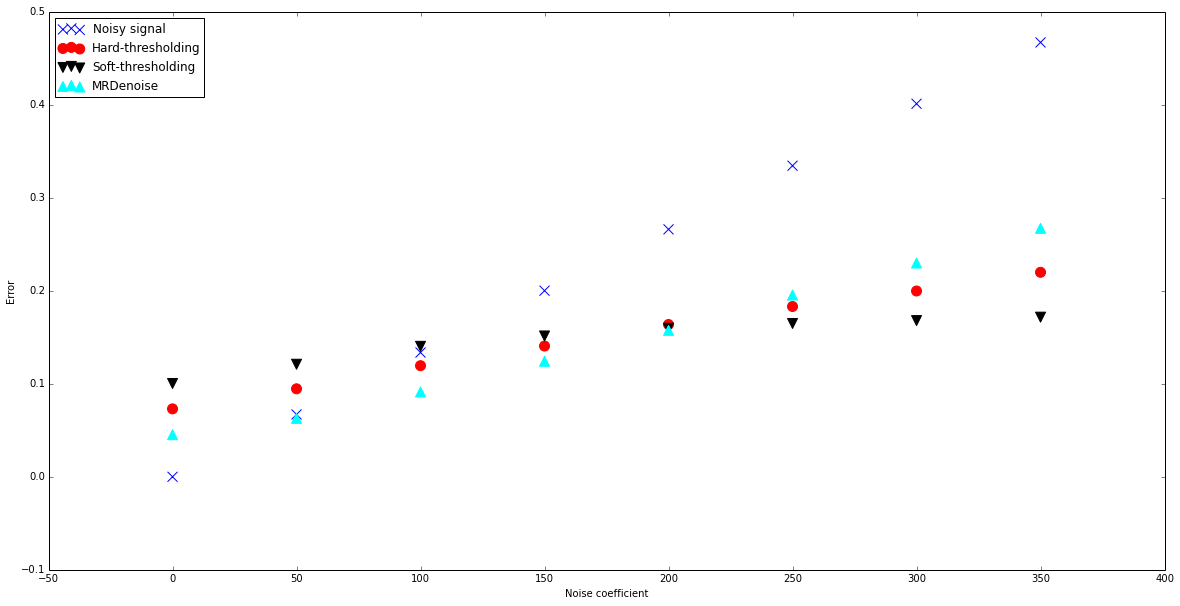

In [153]:
plt.figure(figsize=(20, 10))
a = plt.scatter(range(0, 351, 50), err_bn, color='blue', marker='x', s=100)
b = plt.scatter(range(0, 351, 50), err_ht, color='red', marker='o', s=100)
c = plt.scatter(range(0, 351, 50), err_st, color='black', marker='v', s=100)
d = plt.scatter(range(0, 351, 50), err_mr, color='cyan', marker='^', s=100)
plt.legend(
    (a, b, c, d), ('Noisy signal', 'Hard-thresholding', 'Soft-thresholding',
                   'MRDenoise'),
    loc='upper left')
plt.xlabel('Noise coefficient')
plt.ylabel('Error')
plt.show()

#### We can see that the algorithms seem to work for denoising images. The error is significantly lower than the sampled signal for each of the four algorithms as long as the noise is not too small. If the noise is too small (coefficient of 50 or 100), we can see that the soft-thresholding and the hard-thresholding methods yield larger errors than the initial signal. When the noise gets larger, these methods seem to work very well. On the contrary, the MR Denoise method seem to work best for little noises and a bit worse for larger noises. 

### Hence, one can choose the right method according the level of noise in the image to denoise.

### Second, the error as a function of the proportion of sampled measurements.

In [9]:
from copy import deepcopy as dp
err_bn = []
err_st = []
err_ht = []
err_mr = []

for k in range(10):

    hdulist = pyf.open('data_tp2/ngc2997.fits')
    x = np.double(hdulist[0].data)
    hdulist.close()
    
    x2 = dp(x)

    # Get sampled measurements

    for i in range(len(x)):
        for j in range(len(x[i])):
            if random.uniform(0, 1) < (k+1)*0.1:
                x2[i][j] = 0

    n = 0 * np.random.randn(256, 256)

    bn = x2 + n

    err_bn.append(
        np.linalg.norm(x - bn, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))

    x_st = models.SoftTHRD(bn, J=3, kmad=2.4)
    err_st.append(
        np.linalg.norm(x - x_st, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))
    x_ht = models.HardTHRD(bn, J=3, kmad=2.4)
    err_ht.append(
        np.linalg.norm(x - x_ht, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))
    x_mr, mask = models.MRDenoise(bn, J=3, nmax=25, kmad=2.4)
    err_mr.append(
        np.linalg.norm(x - x_mr, ord=None, axis=None, keepdims=False) /
        np.linalg.norm(x, ord=None, axis=None, keepdims=False))

    print(k + 1, 'iterations done')

(1, 'iterations done')
(2, 'iterations done')
(3, 'iterations done')
(4, 'iterations done')
(5, 'iterations done')
(6, 'iterations done')
(7, 'iterations done')
(8, 'iterations done')
(9, 'iterations done')
(10, 'iterations done')


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


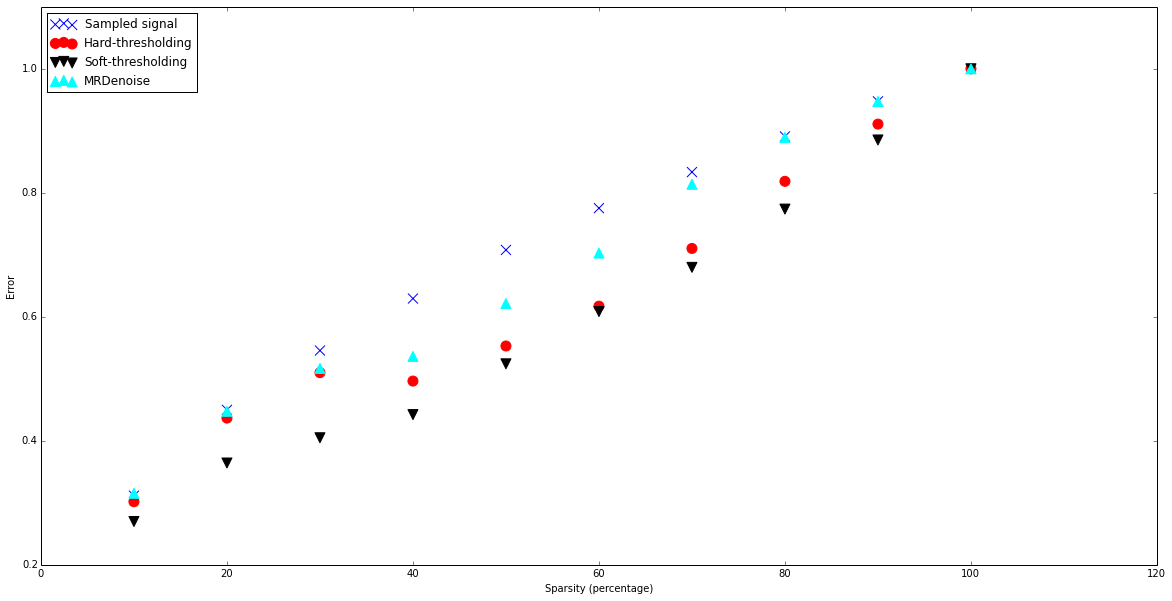

In [10]:
plt.figure(figsize=(20, 10))
a = plt.scatter(range(10, 101, 10), err_bn, color='blue', marker='x', s=100)
b = plt.scatter(range(10, 101, 10), err_ht, color='red', marker='o', s=100)
c = plt.scatter(range(10, 101, 10), err_st, color='black', marker='v', s=100)
d = plt.scatter(range(10, 101, 10), err_mr, color='cyan', marker='^', s=100)
plt.legend(
    (a, b, c, d), ('Sampled signal', 'Hard-thresholding', 'Soft-thresholding',
                   'MRDenoise'),
    loc='upper left')
plt.xlabel('Sparsity (percentage)')
plt.ylabel('Error')
plt.show()

#### We can see that the algorithms seem to work for reconstructing images. The error is significantly lower than the sampled signal for each of the four algorithms as long as the sparsity is not 100%. The soft-thresholding method seem to work best : it has the lowest error for each of the 10 experiments (a range of sparsity percentages from 10% to 100%).

# Let's try the algorithms on 3 other galaxy images

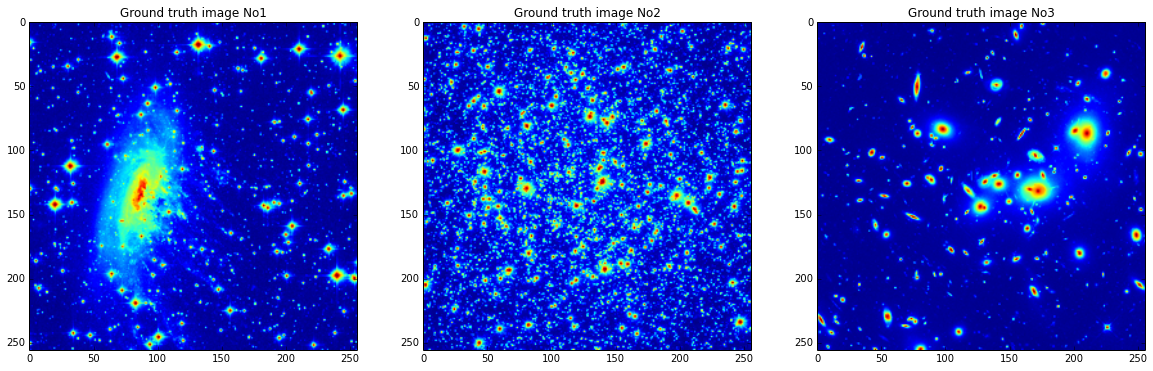

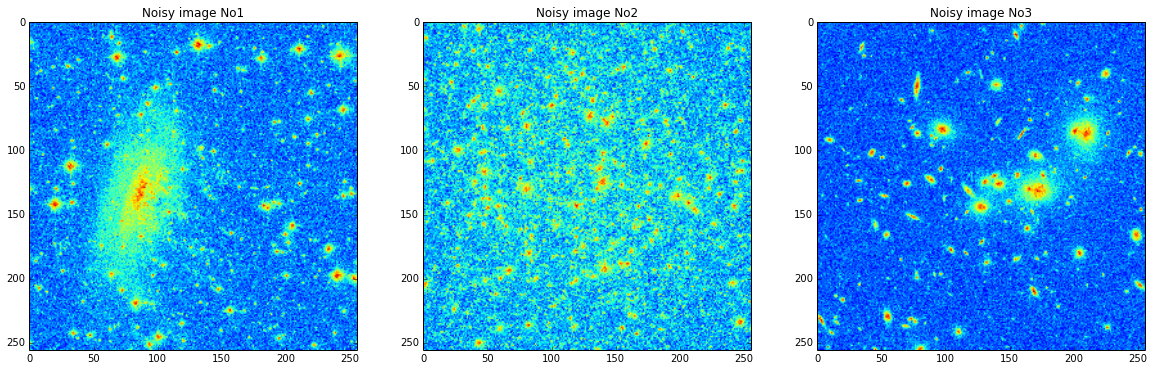

('Image ', 1, ' processed')
('Image ', 2, ' processed')
('Image ', 3, ' processed')


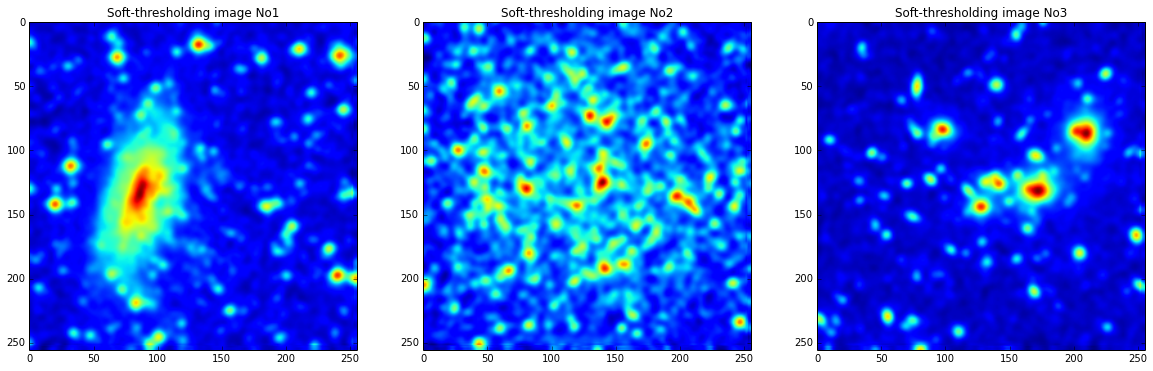

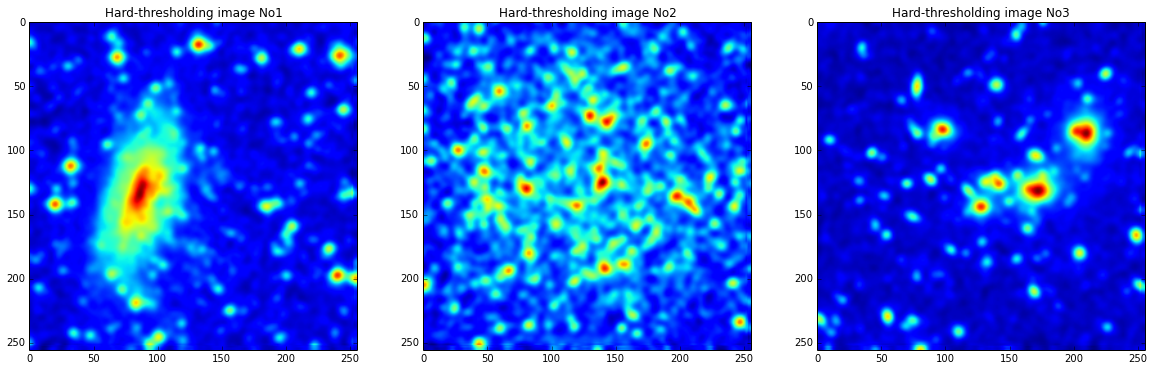

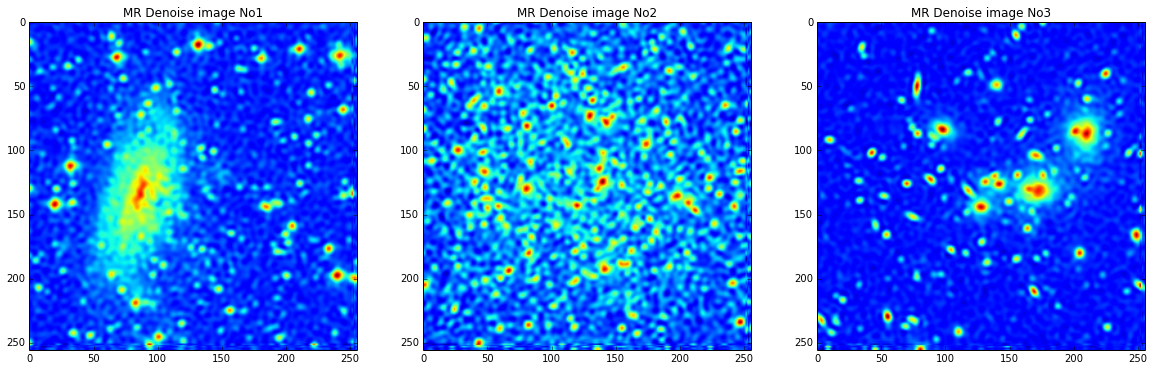

In [55]:

# Get the data

hdulist = pyf.open('AstroImages.fits')
x=[]
x.append(np.double(hdulist[0].data[0]))
x.append(np.double(hdulist[0].data[1]))
x.append(np.double(hdulist[0].data[2]))
hdulist.close()

fig=plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x[i])
    plt.title('Ground truth image No'+str(i+1))
plt.show()

# Add some noise
bn=[0,0,0]
for i in range(3):
    n = 0.002 * np.random.randn(256, 256)
    bn[i] = x[i] + n
    
fig=plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(bn[i])
    plt.title('Noisy image No'+str(i+1))
plt.show()

# Compute the reconstructed image
x_st=[0,0,0]
x_ht=[0,0,0]
x_mr=[0,0,0]
for i in range(3):
    
    x_st[i] = models.SoftTHRD(bn[i], J=3, kmad=40)
    x_ht[i] = models.HardTHRD(bn[i], J=3, kmad=40)
    x_mr[i], mask = models.MRDenoise(bn[i], J=3, nmax=25, kmad=40)
    print('Image ',i+1,' processed')

fig=plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x_st[i])
    plt.title('Soft-thresholding image No'+str(i+1))
plt.show()

fig=plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x_ht[i])
    plt.title('Hard-thresholding image No'+str(i+1))
plt.show()

fig=plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x_mr[i])
    plt.title('MR Denoise image No'+str(i+1))
plt.show()

## The results seems really similar to those of the first image. 